<a href="https://colab.research.google.com/github/RahulGopinath31/NewsArticle_classification/blob/main/NewsArticle_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **News Article Classification**



To build a system that can accurately classify previously unseen news articles
into the right category.

Evalutation Metrics to be used : Accuracy

In [1]:
## importing the necessary library
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import nltk
import sklearn


from tensorflow import keras
from keras.preprocessing.text import text_to_word_sequence
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
#3 reading the csv file
dataset = pd.read_csv('/content/BBC News.csv')

In [3]:
dataset.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [4]:
target_category = dataset['Category'].unique()
print(target_category)

['business' 'tech' 'politics' 'sport' 'entertainment']


In [5]:
dataset['categoryId'] = dataset['Category'].factorize()[0]
dataset.head()

,ArticleId,Text,Category,categoryId
0,1833,worldcom ex-boss launches defence lawyers defe...,business,0
1,154,german business confidence slides german busin...,business,0
2,1101,bbc poll indicates economic gloom citizens in ...,business,0
3,1976,lifestyle governs mobile choice faster bett...,tech,1
4,917,enron bosses in $168m payout eighteen former e...,business,0


In [6]:
category = dataset[["Category","categoryId"]].drop_duplicates().sort_values('categoryId')
category

,Category,categoryId
0,business,0
3,tech,1
5,politics,2
6,sport,3
7,entertainment,4


In [7]:
dataset.groupby('Category').categoryId.count()

Category
business         336
entertainment    273
politics         274
sport            346
tech             261
Name: categoryId, dtype: int64

### *Data Visualization*

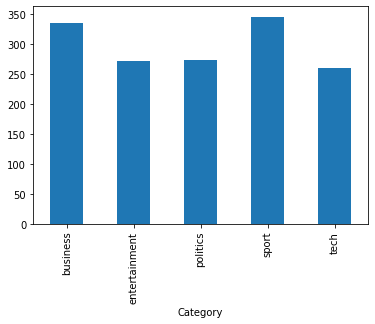

In [8]:
dataset.groupby('Category').categoryId.count().plot.bar(ylim=0)

In [9]:
text = dataset["Text"] 
text.head()

0    worldcom ex-boss launches defence lawyers defe...
1    german business confidence slides german busin...
2    bbc poll indicates economic gloom citizens in ...
3    lifestyle  governs mobile choice  faster  bett...
4    enron bosses in $168m payout eighteen former e...
Name: Text, dtype: object

In [10]:
category = dataset["Category"]
category.head()

0    business
1    business
2    business
3        tech
4    business
Name: Category, dtype: object

In [14]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [16]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [17]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [12]:


def preprocessDataset(train_text):
       
    #word tokenization using text-to-word-sequence
    train_text= str(train_text)
    tokenized_train_set = text_to_word_sequence(train_text,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',lower=True,split=" ")
        
    #stop word removal
    stop_words = set(stopwords.words('english'))
    stopwordremove = [i for i in tokenized_train_set if not i in stop_words]
        
     
    #join words into sentence
    stopwordremove_text = ' '.join(stopwordremove)
        
        
    #remove numbers
    numberremove_text = ''.join(c for c in stopwordremove_text if not c.isdigit())

     #--Stemming--
    stemmer= PorterStemmer()

    stem_input=nltk.word_tokenize(numberremove_text)
    stem_text=' '.join([stemmer.stem(word) for word in stem_input])
        
        
    lemmatizer = WordNetLemmatizer()

    def get_wordnet_pos(word):
        """Map POS tag to first character lemmatize() accepts"""
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

        return tag_dict.get(tag, wordnet.NOUN)

    lem_input = nltk.word_tokenize(stem_text)
    lem_text= ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in lem_input])

    return lem_text
        
       

In [18]:
dataset['Text'] = dataset['Text'].apply(preprocessDataset)
text = dataset['Text']
category = dataset['Category']
text.head()

0    worldcom ex bos launch defenc lawyer defend fo...
1    german busi confid slide german busi confid fe...
2    bbc poll indic econom gloom citizen major nati...
3    lifestyl govern mobil choic faster well funkie...
4    enron bos m payout eighteen former enron direc...
Name: Text, dtype: object

##### split the datframe into train and test set

In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(text,category, test_size = 0.3, random_state = 60,shuffle=True, stratify=category)

print(len(X_train))
print(len(X_test))

1043
447


### Multinomical Navie Bayes

In [20]:
nb = Pipeline([('tfidf', TfidfVectorizer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train,Y_train)

test_predict = nb.predict(X_test)

train_accuracy = round(nb.score(X_train,Y_train)*100)
test_accuracy =round(accuracy_score(test_predict, Y_test)*100)


print("Naive Bayes Train Accuracy Score : {}% ".format(train_accuracy ))
print("Naive Bayes Test Accuracy Score  : {}% ".format(test_accuracy ))
print()
print(classification_report(test_predict, Y_test, target_names=target_category))

Naive Bayes Train Accuracy Score : 99% 
Naive Bayes Test Accuracy Score  : 96% 

               precision    recall  f1-score   support

     business       0.98      0.94      0.96       105
         tech       0.93      1.00      0.96        76
     politics       0.93      0.94      0.93        81
        sport       1.00      0.98      0.99       106
entertainment       0.96      0.95      0.96        79

     accuracy                           0.96       447
    macro avg       0.96      0.96      0.96       447
 weighted avg       0.96      0.96      0.96       447



### Decision Tree

In [21]:
dt = Pipeline([('tfidf', TfidfVectorizer()),
                ('dt', DecisionTreeClassifier()),
               ])

dt.fit(X_train, Y_train)

test_predict = dt.predict(X_test)

train_accuracy = round(dt.score(X_train,Y_train)*100)
test_accuracy =round(accuracy_score(test_predict, Y_test)*100)

print("Decision Tree Train Accuracy Score : {}% ".format(train_accuracy ))
print("Decision Tree Test Accuracy Score  : {}% ".format(test_accuracy ))
print()
print(classification_report(test_predict, Y_test, target_names=target_category))

Decision Tree Train Accuracy Score : 100% 
Decision Tree Test Accuracy Score  : 78% 

               precision    recall  f1-score   support

     business       0.69      0.81      0.75        86
         tech       0.68      0.80      0.74        70
     politics       0.77      0.76      0.76        83
        sport       0.93      0.78      0.85       124
entertainment       0.81      0.75      0.78        84

     accuracy                           0.78       447
    macro avg       0.78      0.78      0.78       447
 weighted avg       0.79      0.78      0.78       447



### Random Forest Classifier

In [22]:
rfc = Pipeline([('tfidf', TfidfVectorizer()),
                ('rfc', RandomForestClassifier(n_estimators=100)),
               ])

rfc.fit(X_train, Y_train)

test_predict = rfc.predict(X_test)

train_accuracy = round(rfc.score(X_train,Y_train)*100)
test_accuracy =round(accuracy_score(test_predict, Y_test)*100)

print("Random Forest Classifier Train Accuracy Score : {}% ".format(train_accuracy ))
print("Random Forest Classifier Test Accuracy Score  : {}% ".format(test_accuracy ))
print()
print(classification_report(test_predict, Y_test, target_names=target_category))

K-Nearest Neighbour Train Accuracy Score : 100% 
K-Nearest Neighbour Test Accuracy Score  : 94% 

               precision    recall  f1-score   support

     business       0.97      0.91      0.94       108
         tech       0.90      1.00      0.95        74
     politics       0.91      0.91      0.91        82
        sport       1.00      0.95      0.98       109
entertainment       0.91      0.96      0.93        74

     accuracy                           0.94       447
    macro avg       0.94      0.95      0.94       447
 weighted avg       0.95      0.94      0.94       447



##### Observation:

*Multinomical Navie Bayes gives a better accuracy for train and test set*